In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog 
from numpy.linalg import solve
import urllib.request
import os
import day_ahead
import pulp as plp

### Downloading and parsing data

In [2]:
if not os.path.exists('data'):
    os.makedirs('data')

url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/consumption-prognosis_2019_hourly.xls" 
urllib.request.urlretrieve(url, 'data/consumption.xls');

consumptionProg_raw_data = pd.read_html('data/consumption.xls')[0].values
consumptionProg_df = pd.DataFrame(consumptionProg_raw_data)
consumptionProg_df.columns = ['Dates', 'Hours', 'NO', 'SE', 'FI', 'DK1', 'DK2', 'EE', 'LV', 'LT']
consumptionProg_df = consumptionProg_df[['Dates', 'Hours', 'DK1', 'DK2']]
consumptionProg_df['Hours'] = consumptionProg_df['Hours'].str.slice(stop=2)
consumptionProg_df['ts'] = pd.to_datetime(consumptionProg_df['Dates'] + consumptionProg_df['Hours'] + ':00', format='%d-%m-%Y%H:%M')
consumptionProg_df = consumptionProg_df[consumptionProg_df['ts'] < pd.to_datetime('2019-02-01')]

## Including Import of DK1 -> Norway 200MW
consumptionProg_df['DK1'] = consumptionProg_df['DK1'] + 200

## Including Export of DK1 -> Germany 100MW
for i in consumptionProg_df.index:
    if (consumptionProg_df['ts'][i].time() >= pd.to_datetime('07:00:00').time()) & (consumptionProg_df['ts'][i].time() < pd.to_datetime('14:00:00').time()):
        consumptionProg_df['DK1'][i] = consumptionProg_df['DK1'][i] - 100
        
## Including Import of DK2 -> Sweden 150MW
for i in consumptionProg_df.index:
    if (consumptionProg_df['ts'][i].time() >= pd.to_datetime('13:00:00').time()) & (consumptionProg_df['ts'][i].time() < pd.to_datetime('19:00:00').time()):
        consumptionProg_df['DK2'][i] = consumptionProg_df['DK2'][i] + 150

C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
url2 = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_2019_hourly.xls" 
urllib.request.urlretrieve(url2, 'data/wind-prognosis.xls');

windProg_raw_data = pd.read_html('data/wind-prognosis.xls')[0].values
windProg_df = pd.DataFrame(windProg_raw_data)
windProg_df.columns = ['Dates', 'Hours', 'DK1', 'DK2']
windProg_df['Hours'] = windProg_df['Hours'].str.slice(stop=2)
windProg_df['ts'] = pd.to_datetime(windProg_df['Dates'] + windProg_df['Hours'] + ':00', format='%d-%m-%Y%H:%M')
windProg_df = windProg_df[windProg_df['ts'] < pd.to_datetime('2019-02-01')]

windProg_df['WW1'] = windProg_df['DK1']*(1/4)
windProg_df['WW2'] = windProg_df['DK1']*(3/4)
windProg_df['EW1'] = windProg_df['DK2']*(1/3)
windProg_df['EW2'] = windProg_df['DK2']*(2/3)

In [32]:
cost_g = np.array([0, 0, 0, 0, 70, 64, 153, 82, 89, 25, 250, 19, 43, 39, 36, 31, 5, 10, 250])
region_g = ['DK1', 'DK1', 'DK2', 'DK2', 'DK1', 'DK1', 'DK1', 'DK1', 'DK1', 'DK1','DK1', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2']
power_g_all = np.array([400, 330, 345, 390, 510, 1000, 900, 1200, 320, 360, 400, 350, 730, 630, 800])
power_g_rest = np.array([400, 330, 345, 390, 510, 0, 900, 0, 320, 360, 400, 350, 730, 630, 800])

In [5]:
generationProg_df = windProg_df.drop(['Dates', 'Hours', 'DK1', 'DK2'], axis=1)

for i in range(15):
    generationProg_df['G{}'.format(i+1)] = power_g_rest[i]
    
for i in generationProg_df.index:
    if (generationProg_df['ts'][i].time() >= pd.to_datetime('05:00:00').time()) & (generationProg_df['ts'][i].time() < pd.to_datetime('22:00:00').time()):
        generationProg_df['G6'][i] = power_g_all[5]
        generationProg_df['G8'][i] = power_g_all[7]

C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
schedule_g = {}
schedule_d = {}
price = {}

limit = 600

for i in range(len(consumptionProg_df)):
    g_df = pd.DataFrame({'ID' : list(generationProg_df)[1:],
                         'region' : region_g,
                         'power_g' : generationProg_df[list(generationProg_df)[1:]].values[i],
                         'cost_g' : cost_g})

    d_df = pd.DataFrame({'ID' : ['D1','D2'],
                         'region' : list(consumptionProg_df)[2:-1],
                         'power_d' : consumptionProg_df[list(consumptionProg_df)[2:-1]].values[i],
                         'cost_d' : [99999, 99999]})
    
    schedule_g[consumptionProg_df['ts'][i]], schedule_d[consumptionProg_df['ts'][i]], price[consumptionProg_df['ts'][i]] = day_ahead.solver(g_df, d_df, limit)

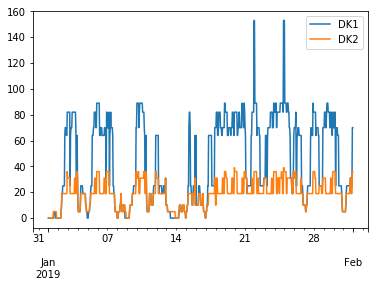

In [34]:
pd.DataFrame(price).T.plot()

### Suppliers Dictionary

In [ ]:
suppliers_dict = {'G1' : 'FlexiGas',
                 'G2' : 'FlexiGas',
                 'G3' : 'FlexiGas',
                 'G4' : 'Peako',
                 'G5' : 'Peako',
                 'G6' : 'Nuke22',
                 'G7' : 'CoalAtLast',
                 'G8' : 'Nuke22',
                 'G9' : 'RoskildeCHP',
                 'G10' : 'RoskildeCHP',
                 'G11' : 'Avedovre',
                 'G12' : 'Avedovre',
                 'G13' : 'BlueWater',
                 'G14' : 'BlueWater',
                 'G15' : 'CoalAtLast'}